In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import asymNdimPdf as apdf

In [23]:
import matplotlib as mpl
mpl.rcParams['legend.frameon']  = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize']  = 18
mpl.rcParams['axes.labelsize']  = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize']  = (10, 7)

In [2]:
cov = np.array([
    [ 1.0000, -0.1949,  0.2583, -0.3933],
    [-0.1949,  1.0000, -0.1188,  0.2919],
    [ 0.2583, -0.1188,  1.0000, -0.3443],
    [-0.3933,  0.2919, -0.3443,  1.0000],
])

measList = np.array([
    [294288603.77097332, 29726222.606283784, -23672504.108643234],
    [1422822752.7824574, 34181144.593426704, -33513316.302916765],
    [1267256904.8604925, 34413027.555306196, -32740743.069167614],
    [189913774.63168541, 17348726.511133254, -19868612.427323759],
])
measList = np.abs(measList) * 1e-6

In [3]:
snParams = []
for m in measList:
    snParams.append(apdf.paramFromMeas(m[0], m[2], m[1]))

In [4]:
# N-dim PDF
loc, scale, alpha = [], [], []
for p in snParams:
    loc.append(p[0])
    scale.append(p[1])
    alpha.append(p[2])

ndSN = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov, alpha=alpha)

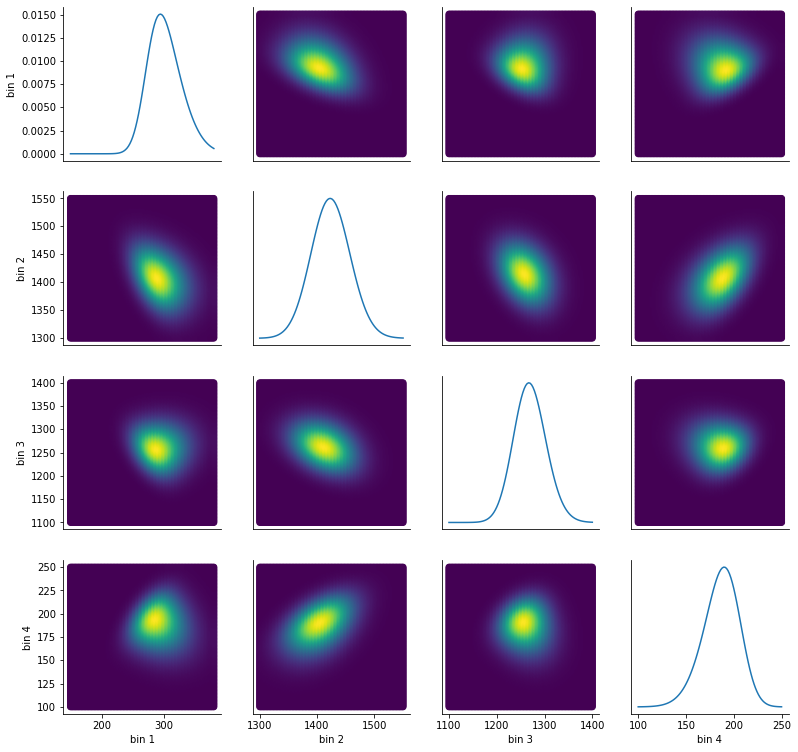

In [5]:
# Random variable ranges
borders = [ 
          [ 150,  380], 
          [1300, 1550],
          [1100, 1400],
          [ 100,  250],
         ]

varName = ['bin 1', 'bin 2', 'bin 3', 'bin 4']

# Plotting each variable pair
ndSN.plot(varNames=varName, borders=borders, nPoints=100, contour=False)

(10092, 4)


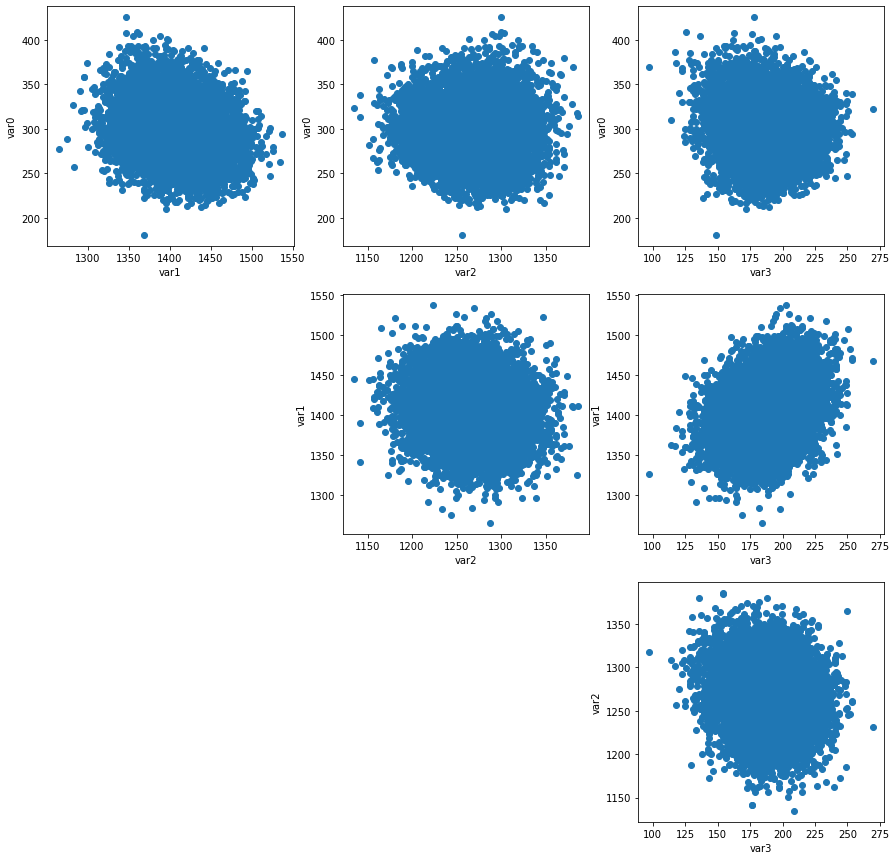

In [6]:
data = ndSN.generateDataFromGauss()
print(data.shape)

apdf.plotDataProj2D(data)

In [7]:
def getBorders(sn):
    borders = []
    for i in range(sn.dim):
        loc, scale, alpha = sn.loc[i], sn.scale[i, i], sn.alpha[i]
        sn_tmp = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
        v, m, p = sn_tmp.measAsymError()
        borders.append([v-3*m, v+3*p])
    return np.array(borders)

def getToysGaussian(n):
    '''
    Sampling based on gaussians PDFs
    '''
    
    Xs = []
    loc, scale = [], []
    for m in measList:
        loc.append(m[0])
        scale.append(max(m[1], m[2])*2)

    Xs = np.random.normal(loc=loc, scale=scale, size=(n, 4))
    Ys = np.random.rand(n) * np.max(ndSN.pdf(Xs))
    
    return Xs[ndSN.pdf(Xs)>=Ys]

In [8]:
data=getToysGaussian(9000000)
print(data.shape[0] /9000000. * 100 )

4.1660111111111116


In [9]:
toys = apdf.generateData(ndSN.pdf, n=9000000, borders=[[150, 400], [1300, 1500], [1100, 1400], [100, 250]])
print(toys.shape[0] /9000000. * 100 )

1.3688444444444443


In [11]:
def logPdf(x):
    return np.log(ndSN.pdf(x))

toys = apdf.generateData(logPdf, n=9000000, borders=[[150, 400], [1300, 1500], [1100, 1400], [100, 250]])
print(toys.shape[0] /9000000. * 100 )

0.0


In [26]:
def getNtoys(pdf, nMin, borders, chunck=100000):
    '''
    Specify the wanted number of toys.
    '''
    nToys, data = 0, []
    while nToys<nMin:
        data.append(apdf.generateData(pdf, n=chunck, borders=borders))
        nToys += data[-1].shape[0]
    return np.concatenate(data)

In [29]:
%timeit getNtoys(ndSN.pdf, nMin=200000, borders=borders, chunck=10000)

6.03 s ± 472 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
def getNtoysGaussian(nMin, chunck=100000):
    '''
    Specify the wanted number of toys.
    '''
    nToys, data = 0, []
    while nToys<nMin:
        data.append(getToysGaussian(chunck))
        nToys += data[-1].shape[0]
    return np.concatenate(data)

In [28]:
%timeit getNtoysGaussian(200000, chunck=10000)

2.72 s ± 378 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Trying to sample log(PDF), and weight after

### One dimension

In [218]:
def generateDataLog(pdf, n=10000, borders=[[-5, 5]]):
    
    '''
    Return data following log(PDF) and weights 
    to get back to a distrubtion following PDF.
    '''
    
    # Manage borders and dimension
    borders = np.array(borders)
    nDim    = borders.shape[0]
    
    # Initial space {x1, ... , xn} sampling
    Xs = np.array([np.random.rand(n)*(borders[i][1]-borders[i][0]) + borders[i][0] for i in range(nDim)]).T 
    
    # Final space y sampling
    logY = np.log(pdf(Xs) + 1e-120)
    yMin, yMax =  np.min(logY), np.max(logY)    
    Ys = np.random.rand(n) * (yMax-yMin) + yMin

    # Select accepted points
    data = Xs[logY>=Ys]
    
    # Compute the weights
    w = pdf(data)
    
    # Return data and weights
    return data, w

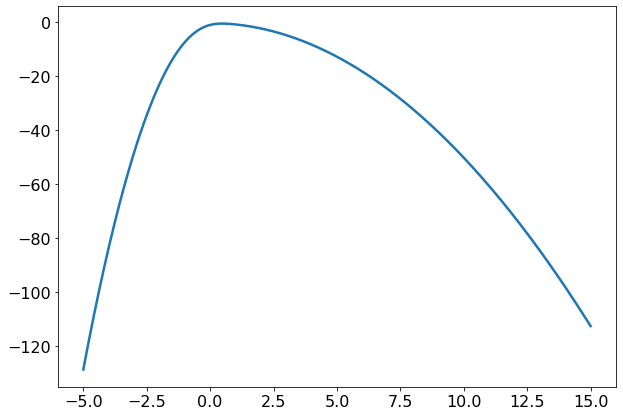

In [219]:
sn = apdf.ndimSkewNormal(alpha=3)
x = np.linspace(-5, 15, 1000)
plt.plot(x, np.log(sn.pdf(x)));

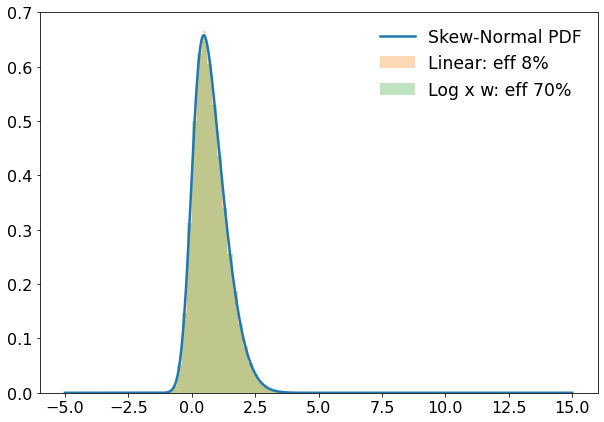

In [220]:
Ngen = 1000000
d1 = apdf.generateData(sn.pdf, n=Ngen, borders=[[-5, 15]])
d2, w = generateDataLog(sn.pdf, n=Ngen, borders=[[-5, 15]])
plt.plot(x, sn.pdf(x), label='Skew-Normal PDF')
plt.hist(d1, density=True, bins=100, alpha=0.3, log=False,
         label='Linear: eff {:.0f}%'.format(d1.shape[0]/Ngen*100))
plt.hist(d2, weights=w, density=True, bins=100, alpha=0.3, 
         label='Log x w: eff {:.0f}%'.format(d2.shape[0]/Ngen*100))
plt.legend();

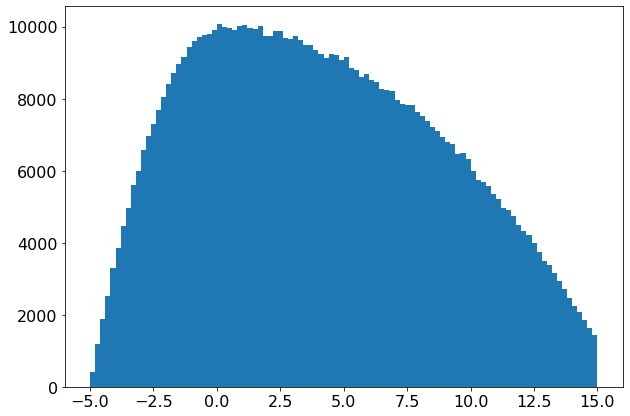

In [221]:
plt.hist(d2, bins=100);

### 4 dimension

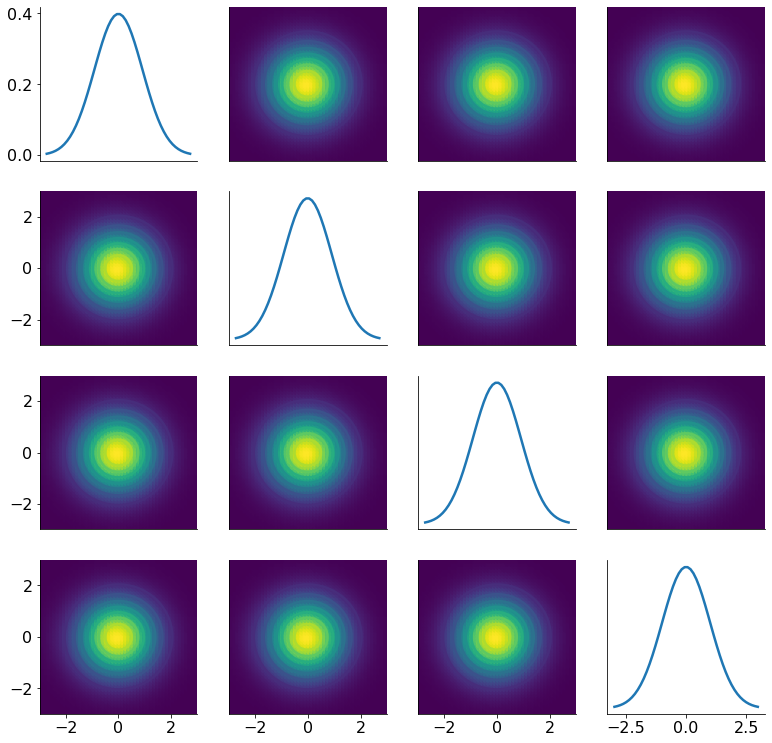

In [185]:
loc   = np.array([0, 0, 0, 0])
scale = np.array([1, 1, 1, 1])
cov   = np.diag([1, 1, 1, 1])
alpha = np.array([0, 0, 0, 0])
sn4d = apdf.ndimSkewNormal(loc, scale, cov, alpha)
sn4d.plot()

In [194]:
Ngen = 9000000
d1    = apdf.generateData(sn4d.pdf, n=Ngen, borders=[[-3, 3]]*4)
d2, w = generateDataLog(sn4d.pdf, n=Ngen, borders=[[-15, 15]]*4)

In [195]:
print('eff: {:.2f}%'.format(d1.shape[0]/Ngen*100))
print('eff: {:.2f}%'.format(d2.shape[0]/Ngen*100))
print(w.shape)

eff: 3.03%
eff: 45.49%
(4094062,)


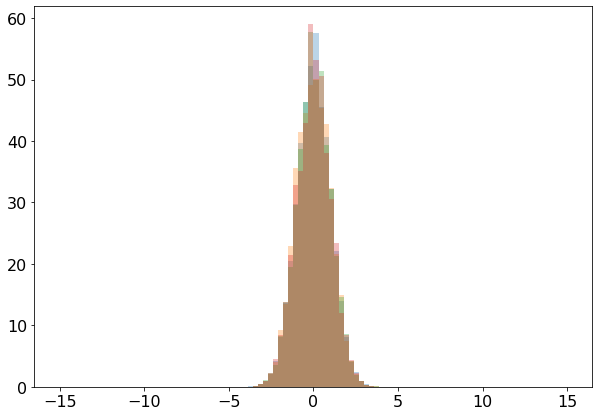

In [201]:
for i in range(4):
    plt.hist(d2[:, i], weights=w, bins=100, alpha=0.3);

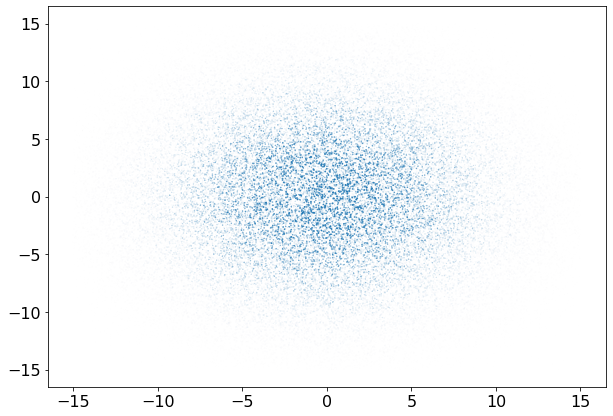

In [197]:
plt.scatter(d2[::50, 2], d2[::50, 3], s=w[::50]**0.1, alpha=0.8);

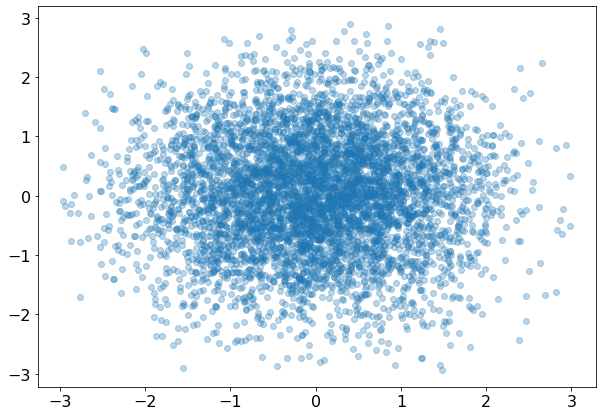

In [199]:
plt.scatter(d1[::50, 0], d1[::50, 1], alpha=0.3);